#1) Importando Bibliotecas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from google.colab import files

#2) Definindo os parâmetros:


In [ ]:
I_0 = 1e-5
S_0 = 1 - I_0
R_0 = 0
beta = 1 # Taxa de transmissão da doença
mu = 0.5 # Taxa de cura
delta = 0.01 # Taxa de perda de imunidade
N = 750 # Número de unidades de tempo que durará a simulação
dt = 0.01 # Intervalo de tempo entre o cálculo de 2 valores da função
NV = 0.6 # Número de vacinas disponíveis (Normalizado)
t0 = 100 # Data de início da vacinação
tf = 200 # Data de término da vacinação
a = NV/(tf - t0) # Taxa de vacinação
t_values = np.arange(0, N, dt) #Valores de tempo usados para fazer os gráficos

#3)Definindo as funções do Modelo SIRS com vacinação

Código do usando a biblioteca solve_ivp do scipy.integrate para o modelo SIRS com vacinação. Esta biblioteca é uma das mais usadas para resolver equações diferenciais. O método de Euler foi substituído por ela para aumentar a eficiência do código.

Definindo a função $\alpha(t)$:

$\alpha(t) = 0, x \notin [t_0, t_{stop}] $

$\alpha(t) = \alpha, x \in [t_0, t_{stop}] $

In [ ]:
def alpha(t0, tf, t, a):
    return np.where(t0 <= t <= tf, a, 0)

def SIRS(t, y, beta, mu, delta, t0, tf):
  S,I,R = y
  dSdt = -beta*S*I + delta*R - alpha(t0, tf, t, a)
  dIdt = beta*S*I -mu*I
  dRdt = mu*I - delta*R + alpha(t0, tf, t, a)
  return [dSdt, dIdt, dRdt]

delta_t = (0, N) #Intervalo no qual ocorrerá a simulação

sol = solve_ivp(SIRS, delta_t, [S_0, I_0, R_0], t=np.linspace(delta_t[0], delta_t[1], int(N/dt)), args = (beta, mu, delta, t0, tf), atol=1e-10, max_step=0.1)

/usr/local/lib/python3.10/dist-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `t`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


O uso da biblioteca solve_ivp tem como objetivo tornar o código mais eficiente e mais veloz, além de garantir uma precisão superior ao método de Euler, visto que esta biblioteca utiliza Runge-Kutta 45 na maioria dos casos.

Após definida a função vamos plotar o gráfico para testar o seu funcionamento:

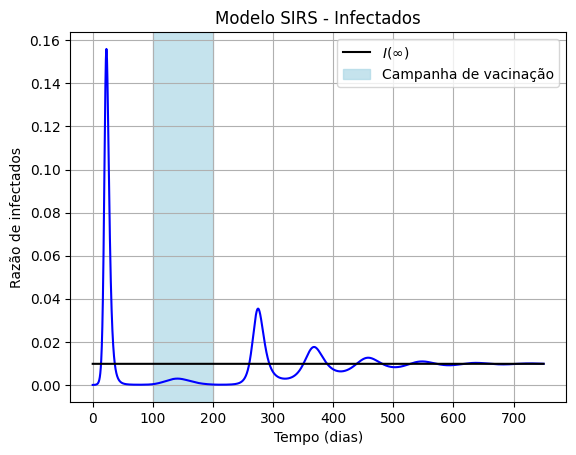

In [ ]:
plt.plot(sol.t, sol.y[1], color = 'blue')
plt.plot(t_values, (1-mu/beta)*(delta/(mu+delta))*np.ones(int(N/dt)), color='black', label = r'$I(\infty)$')
plt.axvspan(t0, tf, color='lightblue', alpha=0.7, label="Campanha de vacinação")
plt.grid()
plt.legend()
plt.xlabel("Tempo (dias)")
plt.ylabel("Razão de infectados")
plt.title("Modelo SIRS - Infectados")
plt.show()

#4) Intensidade rebote x intensidade da vacinação ($\alpha$):


Seguindo o trabalho de (Castioni $\textit{et all}$) vamos tomar o número de vacinas como sendo 0.3. Isso significa que durante a campanha de vacinação $\int{\alpha(t) dt} = 0.3$. Como tomamos $\alpha(t) = \alpha$ a integral nos dá simplesmente que o produto de $\alpha$ pela duranção da campanha de vacinação é igual a 0.3. Desse modo, vamos repetir a parte do artigo que visa determinar o valor ideal de $\alpha$ em nosso de modo, fixados as condições acima. Futuramente pode-se voltar a esta simulação para determinar também qual é o dia ideal para o início da campanha. Por enquanto, iremos apenas assumir o valor dado por (Castioni $\textit{et all}$), que afirma que o dia ideal para o início da vacinação é o dia 89, trabalhando a partir disso com intervalos de tempo de 30 a 150 dias, também usados no artigo supracitado.

Na lista I_max_vac será guardado o valor do máximo no pico após a campanha de vacinação (que é o maior pico em qualquer tempo depois da vacinação).
Já na lista I_min será guardado o valor mínimo de infectados durante a campanha de vacinação, que será um valor bastante útil caso queiramos saber se houve uma possível extinção da epidemia (valores irrsórios de infectados) ou não.

Variáveis usadas ao longo do código:

t0 = Tempo de início da campanha de vacinação

tf = Tempo de parada da campanha de vacinação

I_max = Número máximo de infectados no caso sem vacinação após o dia de início da vacinação no modelo adjacente.

intervalo_t0 = Intervalo de tempo que vai de t0 até o final da simulação

NV = Número de vacinas disponíveis

I_max_vac = Número máximo de infectados após o final da campanha de vacinação

a_tf = Valor de $\alpha$ que minimiza I_max_vac

I_max_vac_0 = Número máximo de infectados após o início da campanha de vacinação

a_t0 = Valor de $\alpha$ que minimiza I_max_vac_0

I_min = Número mínimo de infectados durante a campanha de vacinação. Este é um valor que indica possível extinção da epidemia.

razao_rebote = Vetor que aramzena a razão entre I_max_vac e I_max para cada valor de $\alpha$. Tem como objetivo determinar qual alpha causa maior diminuição relativa do rebote e qual o seu valor.

In [ ]:
NV = 0.3 # Número de vacinas disponíveis (Normalizado)
N = 750 # Número de unidades de tempo que durará a simulação
t0 = 89 # Data de início da vacinação
S0 = 0.99  # População inicial suscetível
I0 = 0.01  # População inicial infectada
R0 = 0
I_max_vac = []
I_min = []
I_max_vac_0 = []
A = []

for j in range(30,151):
  tf = t0 + j
  a = NV/j # Taxa de vacinação
  A.append(a)
  t_eval = np.linspace(0,N, int(N/dt))
  sol = solve_ivp(SIRS, [0, N], [S0, I0, R0], t_eval= t_values,args = (beta, mu, delta, t0, tf), atol=1e-10,  rtol=1e-9)
  intervalo_t0 = np.where(sol.t >= t0)[0][0]  # Índice mais próximo de t0, 1º [0] toma a o elemento da tupla que indica os valores de sol.t maiores que t0, já o segundo [0] seleciona o primeiro termo maior que t0.
  intervalo_tf = np.where(sol.t <= tf)[0][-1] # Índice mais próximo de tf, 1º [0] toma a o elemento da tupla que indica os valores de sol.t maiores que t0, já o segundo [-1] seleciona o primeiro termo menor que tf.
  I_max_vac.append([max(sol.y[1][intervalo_tf:]), a])
  I_min.append([min(sol.y[1][intervalo_t0:]), a])
  I_max_vac_0.append([max(sol.y[1][intervalo_t0:]),a])

Gerando o gráfico de Intensidade rebote x intensidade da vacinação ($\alpha$):

Vamos agora refazer a simulação para I(t) com os dados obtidos acima:

##5.1) Rebote da vacinação x Maior pico sem vacinação (no mesmo período):

Nosso próximo passo será comparar o valor obtido para o rebote com cada $\alpha$ em relação ao maior pico no mesmo período no caso sem vacinação (que está armazenado na variável I_max na simulação abaixo.

Na variável razao_rebote estará armazenada uma lista com a razão entre cada elemento de I_max_vac e I_max.

In [ ]:
I_max_values = [item[0] for item in I_max_vac]
I_max_alphas = [item[1] for item in I_max_vac] #Separando a matriz em suas colunas
I_max_values_0 = [item[0] for item in I_max_vac_0]
I_max_alphas_0 = [item[1] for item in I_max_vac_0]
t_values = [0]
S = [S_0]
I = [I_0]
R = [R_0]

# Método de Euler sem a função alpha pois estamos no caso sem vacinação
for i in range(int(N/dt)):
  S.append(S[i]-beta*I[i]*S[i]*dt+delta*R[i]*dt)
  I.append(I[i] + beta*I[i]*S[i+1]*dt - mu*I[i]*dt)
  R.append(R[i] + mu*I[i+1]*dt-delta*R[i]*dt)
  t_values.append(t_values[i]+dt)
I_max = max(I[intervalo_t0:])

razao_rebote = np.array(I_max_values)/I_max
razao_rebote_alphas = np.array(I_max_alphas)
min_rebote = min(razao_rebote)
indice_razao_rebote = np.argmin(razao_rebote)
print('O valor mínimo da razão entre os rebotes é de:',min_rebote,'para alpha = ', razao_rebote_alphas[indice_razao_rebote])
print(razao_rebote)

O valor mínimo da razão entre os rebotes é de: 0.3697588211813575 para alpha =  0.002
[0.76395919 0.74807021 0.73215138 0.71622367 0.70031152 0.68444239
 0.66864855 0.65296529 0.63743225 0.62209534 0.60700516 0.5922185
 0.57779903 0.5638153  0.55034515 0.5374717  0.5252846  0.51387774
 0.50335025 0.4937997  0.48532294 0.47800707 0.47192828 0.46714401
 0.46368839 0.46156929 0.46076672 0.46123347 0.46289835 0.46567078
 0.46944763 0.47411638 0.47956232 0.48567162 0.49233452 0.49944682
 0.50691175 0.51464101 0.52255379 0.53057702 0.53864596 0.54670225
 0.55469641 0.56258221 0.57032139 0.57787978 0.5852291  0.59234466
 0.59920549 0.60579456 0.61209741 0.61810253 0.62380084 0.62918508
 0.63424977 0.63899191 0.64340808 0.64749722 0.6512592  0.65469446
 0.65780417 0.66058971 0.66305377 0.66519883 0.66702693 0.66854225
 0.66974781 0.67064619 0.67124187 0.67153783 0.67153787 0.67124521
 0.67066353 0.66979632 0.66864702 0.66721862 0.66551474 0.66353851
 0.66129303 0.65878103 0.65600574 0.65296985

##5.2) Valor ideal de alpha: Menor pico durante e após a campanha de vacinação:

Agora vamos mudar ligeiramente o foco da nossa simulação: Ao invés de determinar o valor de $\alpha$ que gera o menor pico após o final da campanha de vacinação, vamos realizar o mesmo processo anterior, porém agora determinando o menor pico a partir do início da campanha de vacinação. (Esta alteração foi feita no código do início da seção 5, com as variáveis intervalo_t0 e I_max_vac_0).

O valor da taxa de vacinação que garante o menor rebote após o final da campanha de vacinação é: 0.002
O valor da taxa de vacinação que garante o menor rebote desde o início da campanha de vacinação é: 0.005357142857142857


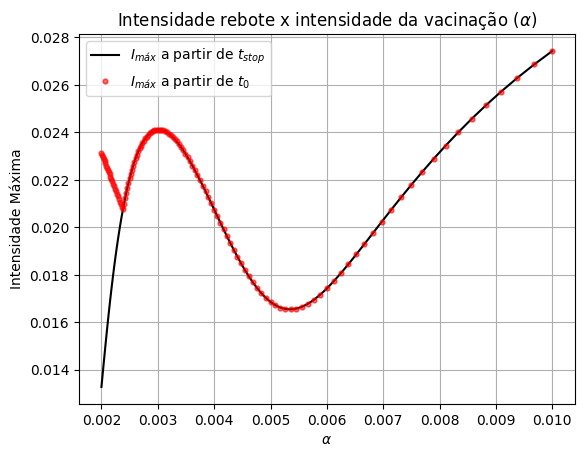

In [ ]:
plt.plot(A, I_max_values, color='black', label = r'$I_{máx}$ a partir de $t_{stop}$')
plt.plot(A, I_max_values_0,'o',markersize=3.5, alpha = 0.6,  color= 'red', label = r'$I_{máx}$ a partir de $t_0$')
plt.title(r"Intensidade rebote x intensidade da vacinação ($\alpha$)")
plt.ylabel('Intensidade Máxima')
plt.xlabel(r'$\alpha$')
plt.grid()
plt.legend()
indice_tf = I_max_vac.index(min(I_max_vac))
indice_t0 = I_max_vac_0.index(min(I_max_vac_0))
print(r'O valor da taxa de vacinação que garante o menor rebote após o final da campanha de vacinação é:',A[indice_tf])
print(r'O valor da taxa de vacinação que garante o menor rebote desde o início da campanha de vacinação é:',A[indice_t0])
a_t0 = A[indice_t0] #Valor de a que minimiza o rebote a partir do início da campanha
a_tf = A[indice_tf] #Valor de a que minimiza o rebote após a campanha

Com o gráfico acima podemos peceber que apesar de o melhor valor de alpha para evitar um rebote após a vacinação seja de 0.002, o valor ideal para picos menores durante a campanha é de 0.0053. Para comparar o desenrolar da epidemia com os dois valores de $\alpha$ obtidos nas simulações, vamos novamente plotar I(t) para ambos os alphas e comparar os resultados.

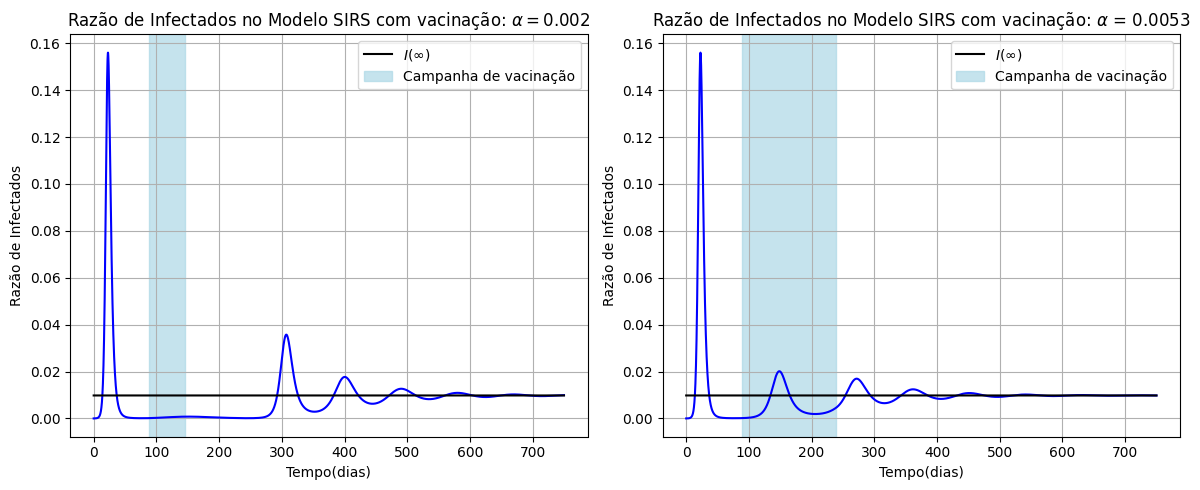

In [ ]:
a = a_t0
sol_a_t0 = solve_ivp(SIRS, delta_t, [S_0, I_0, R_0], t=np.linspace(delta_t[0], delta_t[1], int(N/dt)), args = (beta, mu, delta, t0, tf), atol=1e-10, max_step=0.1)

a = a_tf
sol_a_tf = solve_ivp(SIRS, delta_t, [S_0, I_0, R_0], t=np.linspace(delta_t[0], delta_t[1], int(N/dt)), args = (beta, mu, delta, t0, tf), atol=1e-10, max_step=0.1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(sol_a_t0.t, sol_a_t0.y[1], color = 'blue')
axes[0].plot(t_values, (1-mu/beta)*(delta/(mu+delta))*np.ones(int(N/dt)+1), color='black', label = r'$I(\infty)$')
axes[0].set_title(r"Razão de Infectados no Modelo SIRS com vacinação: $\alpha = 0.002$")
axes[0].set_ylabel('Razão de Infectados')
axes[0].set_xlabel('Tempo(dias)')
axes[0].axvspan(t0, t0+NV/a_t0, color='lightblue', alpha=0.7, label="Campanha de vacinação")
axes[0].grid()
axes[0].legend()

axes[1].plot(sol_a_tf.t, sol_a_tf.y[1], color = 'blue')
axes[1].plot(t_values, (1-mu/beta)*(delta/(mu+delta))*np.ones(int(N/dt)+1), color='black', label = r'$I(\infty)$')
plt.title(r"Razão de Infectados no Modelo SIRS com vacinação: $\alpha$ = 0.0053")
axes[1].set_ylabel('Razão de Infectados')
axes[1].set_xlabel('Tempo(dias)')
axes[1].axvspan(t0, t0+NV/a_tf, color='lightblue', alpha=0.7, label="Campanha de vacinação")
axes[1].grid()
axes[1].legend()

fig.tight_layout()
plt.show()

Como pode-se perceber, um valor mais baixo de $\alpha$ garante um rebote menor após a campanha de vacinação, enquanto que valores um pouco mais elevados derrubam o número de infectados durante a campanha.

#6) Número Mínimo de Infectados durante a campanha:

In [ ]:
I_min_values = [item[0] for item in I_min]
I_min_alphas = [item[1] for item in I_min]
print('A razão mínima de infectados é de:',min(I_min_values), 'quando alpha =', I_min_alphas[np.argmin(I_min_values)])

A razão mínima de infectados é de: 0.0004249073349838775 quando alpha = 0.0024193548387096775


Ou seja, com o número de vacinas igual a 30% da população não ocorre extinção para nenhum valor de alpha testado no presente código, visto que a menor razão de infectados é de 0.00042, o que numa população de $10^5$ significa 42 infectados. Portando nosso próximo passo é identificar para quais quantidades de vacinas é possível haver uma extinção da epidemia. Para tornar essa simulação possível iremos iniciar com o valor fixo de alpha que garante o mínimo de infectados no caso até agora testado, ou seja, $\alpha = 0.0024193$. Também continuaremos deixando fixo o início da simulação para o dia 89 da minulação, como indicado no artigo de (Castioni $\textit{et all}$).

#7) Taxas de vacinação de erradicação e imunidade total
A taxa de vacinação mínima para a erradicação é dada por:

$\alpha = (1 - \frac{1}{R_0}) \cdot \delta$

A erradicação de uma epidemia ocorre quando o número de infectados chega a 0, porém o número de suscetíveis ainda é maior que 0, o que permite uma nova epidemia futura no caso de u reintrodução de um infectado na população.
Calculando o nosso $\alpha$ de erradicação temos:


In [ ]:
R0 = beta/mu
alpha_erradicacao = (1-1/R0)*delta
print(alpha_erradicacao)

0.005


Como calculado no código acima o $\alpha$ de erradicação é de 0.005 no caso dos parâmetros usados nesta simulação, o que significa que uma campanha contínua com tal valor de $\alpha$ acabaria com a epidemia. Porém este não é o nosso interesse aqui, visto que estamos focando em um caso de recursos finitos onde o número de vacinas está predertinado e deve ser aplicado da maneira mais eficiente possível.

Já o $alpha$ de imunidade total é aquele para o qual toda a população se torna imune, cujo valor é dado por:

$\alpha = \delta$

In [ ]:
alpha_imunidade = delta
print(alpha_imunidade)

0.01


Como não estamos interessados em campanhas contínuas, vamos iniciar as campanhas com os valores supracitados de $\alpha$ e da data de início e variar apenas o número de vacinas disponíveis, a fim de determinar o número mínimo que gera extinção da epidemia para uma determinada população.

Fixando os parâmetros:

t0 = 89

N (tamanho da população) = $10^5$

extincao_alpha = Lista onde extincao[i] = 1 se houver extinção e extincao[i] = 0 se não houver extinção da epidemia para um alpha dado

extincao_total = Matriz contendo os dados de extinção_alpha para cada número de vacinas

In [ ]:
t0 = 89
N = 1e5
extincao_alpha = []
extincao_total = []
N_dias = 400
d_alpha = 0.00025
d_NV = 0.005
alpha_values = np.arange(0, 0.015, d_alpha)
NV = np.arange(0,1, d_NV)
def alpha(t0, tf, t, a): #Definindo alpha novamente pois ocorreu um erro no código
  if t0 <= t <= tf:
    return a
  else:
    return 0
for a in alpha_values[1:]:
  extincao_alpha = []
  for i in NV:
    tf = int(t0 + i/a)
    sol = solve_ivp(SIRS, delta_t, [S_0, I_0, R_0], t_eval=np.linspace(delta_t[0], delta_t[1], int(N_dias/dt)), args = (beta, mu, delta, t0, tf), atol=1e-10, max_step=0.1)
    sol = sol.y[1]
    if len(sol[intervalo_t0:]) > 0 and min(sol[intervalo_t0:]) < 0.5/N:
      extincao_alpha.append(1)
    else:
      extincao_alpha.append(0)
  extincao_total.append(extincao_alpha)
print(extincao_total)
extincao_total_csv = pd.DataFrame(extincao_total)
extincao_total_csv.to_csv('matriz.csv', index=False, header=False)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Agora que possuímos as informações se ocorre ou não extinção para cada valor de $alpha$ e de número de vacinas disponíveis, vamos criar um mapa de 2 dimensões que nos permitavisualizar quais combinações dos parâmetros supracitados geram uma extinção.

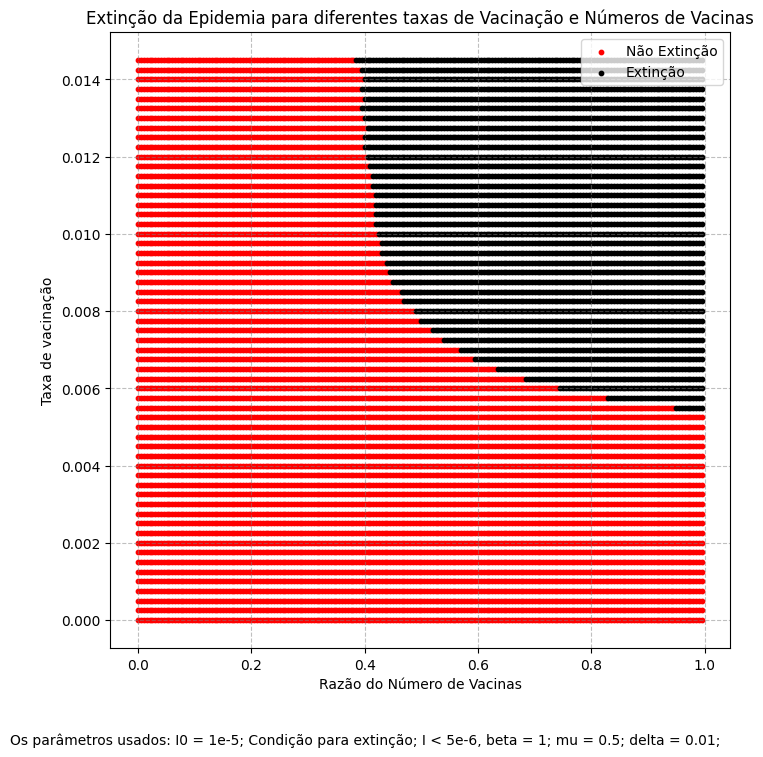

In [ ]:
matriz = np.loadtxt('matriz.csv', delimiter=',')
plt.figure(figsize=(8, 8))

# Variáveis de controle para as legendas
legenda_extincao = True
legenda_nao_extincao = True

# Loop para plotar os pontos
for i in range(matriz.shape[0]):
    for j in range(matriz.shape[1]):
        if matriz[i, j] == 1:
            if legenda_extincao:
                plt.scatter(j * d_NV, i * d_alpha, color='black', s=10, label="Extinção")
                legenda_extincao = False  # Adiciona a legenda uma única vez
            else:
                plt.scatter(j * d_NV, i * d_alpha, color='black', s=10)
        else:
            if legenda_nao_extincao:
                plt.scatter(j * d_NV, i * d_alpha, color='red', s=10, label="Não Extinção")
                legenda_nao_extincao = False  # Adiciona a legenda uma única vez
            else:
                plt.scatter(j * d_NV, i * d_alpha, color='red', s=10)

# Configurações do gráfico
plt.xlabel("Razão do Número de Vacinas")
plt.ylabel("Taxa de vacinação")
plt.title("Extinção da Epidemia para diferentes taxas de Vacinação e Números de Vacinas")
plt.legend()
plt.grid(True, which='both', linestyle='--', color='gray', alpha=0.5)
plt.figtext(0.0, -0.01,'Os parâmetros usados: I0 = 1e-5; Condição para extinção; I < 5e-6, beta = 1; mu = 0.5; delta = 0.01;')
plt.show()

In [ ]:
pd.read_csv('matriz.csv')
files.download('matriz.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>